In [1]:
# 110922
# YIKAI MAO

# generates dataset for demo_1
# single circuit, different layout

In [2]:
# standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit_experiments.library import StandardRB

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
display(provider.backends())

# application libraries
from tqdm import tqdm
import mapomatic as mm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle

%env PYTHONHASHSEED=0

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

env: PYTHONHASHSEED=0


In [3]:
def layer_decomposition(circuit):
    num_qubits = circuit.num_qubits
    layer_pointer = 0
    layer_tracker = [0]*num_qubits
    layers = {}
    locations = {}
    
    for item in circuit.data:
        temp_tracker = []
        location = ""
        
        #print(item)
        #print('layer before,', layer_tracker)
        #print('this item:', item[0].name)
        
        ######################################
        
        if item[0].name == 'barrier':
            #print('barrier, skipped.')
            #print('')
            continue
        
        elif len(item[1]) == 1:
            layer_tracker[circuit.find_bit(item[1][0]).index] += 1
            temp_tracker.append(layer_tracker[circuit.find_bit(item[1][0]).index])
            location += (str(circuit.find_bit(item[1][0]).index))
        
        else:
            for i in range(len(item[1])):
                layer_tracker[circuit.find_bit(item[1][i]).index] += 1
                temp_tracker.append(layer_tracker[circuit.find_bit(item[1][i]).index])
            
            for i in range(len(item[1])):
                layer_tracker[circuit.find_bit(item[1][i]).index] = max(temp_tracker)
                location += str(circuit.find_bit(item[1][i]).index) + ' '
                
        ######################################
            
        if max(layer_tracker) > layer_pointer:
            layer_pointer = max(layer_tracker)
            
            if layer_pointer not in layers:
                layers[layer_pointer-1] = list()
                locations[layer_pointer-1] = list()
                layers[layer_pointer-1].extend([item[0].name])
                locations[layer_pointer-1].extend([location.rstrip()])
            else:
                layers[layer_pointer-1].extend([item[0].name])
                locations[layer_pointer-1].extend([location])
            #print('layer_pointer incremented:', layer_pointer)
        
        else:
            layers[layer_tracker[circuit.find_bit(item[1][0]).index]-1].extend([item[0].name])
            locations[layer_tracker[circuit.find_bit(item[1][0]).index]-1].extend([location.rstrip()])
            #print('layer_pointer no change:', layer_pointer)
        
        #print('layer after,', layer_tracker)
        #print('layers dict = ', layers)
        #print('locations dict = ', locations)
        #print('')
        
        ######################################
        
    return layers, locations

In [4]:
def generate_RB_circuit_samples(lengths, num_samples, qubits, backend, remove_dups, seed):
    
    # lengths (Iterable[int]) = Number of Cliffords in the sequence, a list of RB sequences lengths.
    # num_samples (int) = Number of samples to generate for each sequence length.
    # qubits (Sequence[int]) = list of physical qubits for the experiment.
    
    trans_qc_list = []
    unique_list = []
    dup_list = []
    depth_list = []
    
    print('generating', num_samples*len(lengths), 'RB samples on', backend.name(), ', using qubits:', qubits)
    exp = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
    print('done')
    print('-'*44)
    
    print('transpile all the layouts...')
    i = 0
    for exp_circ in exp.circuits():
        if (i % 50) == 0:
            print('transpiling circuit', i)
        exp_circ = transpile(exp_circ, backend, optimization_level=0)
        deflated_exp_circ = mm.deflate_circuit(exp_circ)
        layouts = mm.matching_layouts(deflated_exp_circ, backend)
        for j in layouts:
            trans_qc = transpile(deflated_exp_circ, backend, initial_layout=j, optimization_level=0)
            trans_qc_list.append(RemoveBarriers()(trans_qc))
        i+=1
    print('done')
    print('-'*44)
    
    if remove_dups:
        print('check duplicates...')
        for i in range(len(trans_qc_list)):
            if (i % 100) == 0:
                print('checking circuit', i)
            trans_circ_layers, trans_circ_locations = layer_decomposition(trans_qc_list[i])
        
            if i in dup_list:
                continue
        
            for j in range(i+1, len(trans_qc_list)):
                la, lo = layer_decomposition(trans_qc_list[j])
                if (la==trans_circ_layers) and (lo==trans_circ_locations):
                    print('same circuit pair:', i, j, 'remove', j)
                    if j not in dup_list:
                        dup_list.append(j)
                #else:
                    #print('diff circuit pair:', i, j)
                
        if len(dup_list) == 0:
            print('no duplicats!')
            print('-'*44)
        
        else:
            #sorted(dup_list)
            #print(dup_list)
            print('done')
            print('-'*44)    
    
    for i in range(len(trans_qc_list)):
        if i not in dup_list:
            unique_list.append(trans_qc_list[i])
    
    # extremely slow for some reason
    #import itertools
    #for a, b in itertools.combinations(range(len(trans_qc_list)), 2):
    #    if trans_qc_list[a].qasm(formatted=False) == trans_qc_list[b].qasm(formatted=False):
    #        print(a, b)
    
    for i in range(len(unique_list)):
        la, lo = layer_decomposition(unique_list[i])
        depth_list.append(len(la))
    print('max circuit depth =', max(depth_list))
    print('min circuit depth =', min(depth_list))
    print('mean circuit depth =', np.mean(depth_list))
    #print(depth_list)
    
    return unique_list

In [5]:
def generate_timesteps(layers, locations, backend):
    timesteps = {}

    for i in range(len(la)):
        timesteps[i] = []
        for j in range(backend.configuration().n_qubits):
            timesteps[i].append('none')

    for i in range(len(la)):
        temp_str = ''
        for j in range(len(lo[i])):
            if la[i][j] != 'cx':
                if la[i][j] == 'id' or la[i][j] == 'reset':
                    # id gate is the same as no connection
                    # does not support reset for now
                    continue
                timesteps[i][int(lo[i][j])] = (temp_str.join(list(zip(la[i],lo[i]))[j]))
            else:
                control = int(lo[i][j].replace(' ', '')[0])
                target = int(lo[i][j].replace(' ', '')[1])
                timesteps[i][control] = (temp_str.join(list(zip(la[i],lo[i]))[j]).replace(' ', ''))
                timesteps[i][target] = (temp_str.join(list(zip(la[i],lo[i]))[j]).replace(' ', ''))
    
    return timesteps

In [6]:
def run_ideal_simulation(circuit, shots, seed):
    # assume perfect device with no noise

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=0)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()

    # expected output is plotted
    #plot = plot_histogram(temp_results.get_counts())
    #plot.patch.set_facecolor('xkcd:white')
    #display(plot)
    #print('raw outputs:')
    #print(temp_results.get_counts())

    # build simulation result dict
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in temp_results.get_counts():
            #print(bin_str + ': probability = 0')
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = temp_results.get_counts()[bin_str]

    #print('simulation result dictionary:')
    #if num_clbits <= 6:
    #    print(ideal_result_dict)
    #else:
    #    print('result too long, skip')
        
    return ideal_result_dict

In [7]:
def generate_labels(backend, circuit, shots, seed, ideal_result_dict):
    
    num_physical_qubits = backend.configuration().n_qubits
    num_clbits = circuit.num_clbits
    
    #print('ideal simulation:')
    #if num_clbits <= 6:
    #    print(ideal_result_dict)
    #else:
    #    print('result too long, skip')
        
    #print('noisy simulation:')
    #if num_clbits <= 6:
    #    print(job.result().get_counts())
    #else:
    #    print('result too long, skip')
    #print('-'*44)
    
    ###################################################################################################################

    circuit_accuracy = {'circuit fidelity': 1}
    
    # calculate coefficient of determination
    #if 'fake' in backend.name():
    #    job = backend.run(circuit, shots=shots, seed_simulator=seed)
    #else:
    backend_sim = AerSimulator.from_backend(backend)
    job = backend_sim.run(circuit, shots=shots, seed_simulator=seed)
    temp_results = job.result()
    #print(len(temp_results.get_counts()))
    #display(plot_histogram(job.result().get_counts()))
    
    qu_to_cl = {}
    for item in circuit.data:
        if item[0].name == 'measure':
            qu_index = circuit.find_bit(item[1][0]).index #qubit index
            cl_index = circuit.find_bit(item[2][0]).index #clbit index
            qu_to_cl['q' + str(qu_index)] = 'c' + str(cl_index)
    #print('qubit to clbit mapping:')
    #print(qu_to_cl)
    
    ###################################################################################################################
    
    temp_result_dict = {}
    # build full result dict
    temp_diff = 0
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in temp_results.get_counts():
            #print(bin_str + ': probability = 0')
            temp_result_dict[bin_str] = 0
        else:
            temp_result_dict[bin_str] = temp_results.get_counts()[bin_str]
    temp_mean = [np.mean(list(ideal_result_dict.values()))] * len(ideal_result_dict)
    #print(temp_mean)
    # accumulate sum of square (residual)
    SS_residual = np.sum(np.square(np.subtract(list(ideal_result_dict.values()), list(temp_result_dict.values()))))
    #print(SS_residual)
    # accumulate sum of square (total)
    SS_total = np.sum(np.square(np.subtract(list(ideal_result_dict.values()), temp_mean)))
    #print(SS_total)
    # coefficient of determination
    R_squared = 1 - (SS_residual / SS_total)
    
    circuit_accuracy['circuit fidelity'] = R_squared
    
    ###################################################################################################################
    
    clbit_counts_perfect = {}
    for i in range(num_clbits):
        clbit_counts_perfect["c{0}_0".format(i)] = 0
        clbit_counts_perfect["c{0}_1".format(i)] = 0
        format_str = '{:0'+ str(num_clbits) +'b}'
        for j in range(2**num_clbits):
            binary_count = format_str.format(j)
            #print(binary_count)
            if binary_count[-(i+1)] == '0':
                try:
                    clbit_counts_perfect["c{0}_0".format(i)] += ideal_result_dict[binary_count]
                except KeyError:
                    clbit_counts_perfect["c{0}_0".format(i)] += 0
            elif binary_count[-(i+1)] == '1':
                try:
                    clbit_counts_perfect["c{0}_1".format(i)] += ideal_result_dict[binary_count]
                except KeyError:
                    clbit_counts_perfect["c{0}_1".format(i)] += 0
        #print('(ideal simulation) count of c' + str(i) + ' = 0 is: ', clbit_counts_perfect["c{0}_0".format(i)])
        #print('(ideal simulation) count of c' + str(i) + ' = 1 is: ', clbit_counts_perfect["c{0}_1".format(i)])
    
    #print('')
    
    clbit_counts = {}
    clbit_accuracy = {}
    qubit_accuracy = {}
    for i in range(num_physical_qubits):
        clbit_accuracy["c{0}".format(i)] = 1
        qubit_accuracy["q{0}".format(i)] = 1
    
    for i in range(num_clbits):
        clbit_counts["c{0}_0".format(i)] = 0
        clbit_counts["c{0}_1".format(i)] = 0
        format_str = '{:0'+ str(num_clbits) +'b}'
        for j in range(2**num_clbits):
            binary_count = format_str.format(j)
            #print(binary_count)
            if binary_count[-(i+1)] == '0':
                try:
                    clbit_counts["c{0}_0".format(i)] += job.result().get_counts()[binary_count]
                except KeyError:
                    clbit_counts["c{0}_0".format(i)] += 0
            elif binary_count[-(i+1)] == '1':
                try:
                    clbit_counts["c{0}_1".format(i)] += job.result().get_counts()[binary_count]
                except KeyError:
                    clbit_counts["c{0}_1".format(i)] += 0
        
        test_0_count = abs(clbit_counts_perfect["c{0}_0".format(i)] - clbit_counts["c{0}_0".format(i)])
        test_1_count = abs(clbit_counts_perfect["c{0}_1".format(i)] - clbit_counts["c{0}_1".format(i)])
        if test_0_count != test_1_count:
            print("!!!something's wrong!!!")
        
        clbit_accuracy["c{0}".format(i)] = 1 - (abs(clbit_counts_perfect["c{0}_0".format(i)] - clbit_counts["c{0}_0".format(i)])/shots)
        #print('(noisy simulation) count of c' + str(i) + ' = 0 is: ', clbit_counts["c{0}_0".format(i)])
        #print('(noisy simulation) count of c' + str(i) + ' = 1 is: ', clbit_counts["c{0}_1".format(i)])
    
    #print('')
        
    ###################################################################################################################
    
    #if R_squared <= 0:
    #    print('circuit fidelity =', R_squared, 'R_squared <= 0, result extremely bad/noisy')
    #else:
    #    print('circuit fidelity =', R_squared)
        
    #for i in range(num_physical_qubits):    
    #    print('c' + str(i) + ' fidelity =', clbit_accuracy["c{0}".format(i)])
        
    ###################################################################################################################
    
    for i in qu_to_cl:
        qubit_accuracy[i] = clbit_accuracy[qu_to_cl[i]]
    
    return circuit_accuracy, qubit_accuracy

In [9]:
# define circuit here, either a Qiskit circuit object or OpenQASM string
qasm_str = '''



'''

#circuit = QuantumCircuit.from_qasm_str(qasm_str)

In [10]:
from qiskit.providers.fake_provider import *
import warnings

# ignore T2/T1 warinings
warnings.filterwarnings("ignore")

#backend = provider.get_backend('ibm_nairobi')
backend = FakeMontreal()

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 15064.20it/s]


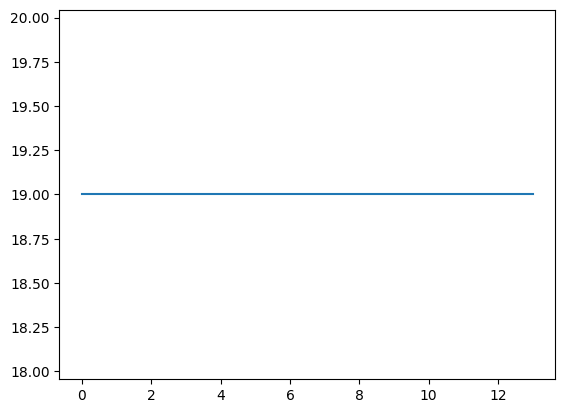

generated 14 circuits.


In [23]:
seed = None
circuit_list = []

transpiled_circ = transpile(circuit, backend, optimization_level=3) # check optimization level!
deflated_circ = mm.deflate_circuit(transpiled_circ)
layouts = mm.matching_layouts(deflated_circ, backend)
for j in tqdm(layouts):
    trans_qc = transpile(deflated_circ, backend, initial_layout=j, optimization_level=0)
    circuit_list.append(RemoveBarriers()(trans_qc))

#depths = []
#for i in tqdm(range(len(circuit_list))):
#    depths.append(circuit_list[i].depth())
#plt.plot(sorted(depths))
#plt.show()

print('generated', len(circuit_list), 'circuits.')

In [98]:
#with open('circuit_data_generator_single.pickle', 'wb') as f:
#    pickle.dump(circuit_list, f, pickle.HIGHEST_PROTOCOL)
circuit_list = []
#with open('circuit_list_for_generator_single.pickle', 'rb') as f:
#    circuit_list.append(pickle.load(f))
with open('circuit_list_for_generator.pickle', 'rb') as f:
    circuit_list = (pickle.load(f))

In [99]:
shots = 1024
seed = 4444

circuit_list_shuffled = circuit_list # do not shuffled if loading from pickle
#circuit_list_shuffled = random.sample(circuit_list, len(circuit_list))
f = open('circuit_data_generator_single.csv', 'w')
df = pd.DataFrame(columns = ['depth', 'circuit', 'circuit_fidelity', 'qubit_fidelity'])
df.to_csv("circuit_data_generator_single.csv", mode='a', index=False)

for i in tqdm(range(len(circuit_list_shuffled))):
    circuit = circuit_list_shuffled[i]
    ideal_result_dict = run_ideal_simulation(circuit, shots, seed)
    circuit_fidelity, qubit_fidelity = generate_labels(backend, circuit, shots, seed, ideal_result_dict)
    la, lo = layer_decomposition(circuit)

    circuit_depth = [str(circuit.depth())]
    timestep_str = ['; '.join(map(' '.join, generate_timesteps(la, lo, backend).values()))]
    circuit_fidelity = ['; '.join(map(str, list(circuit_fidelity.values())))]
    qubit_fidelity = ['; '.join(map(str, list(qubit_fidelity.values())))]
    df = pd.DataFrame(list(zip(circuit_depth, timestep_str, circuit_fidelity, qubit_fidelity)))
    df.to_csv("circuit_data_generator_single.csv", mode='a', index=False, header=False)
f.close()

100%|█████████████████████████████████████████| 792/792 [15:54<00:00,  1.21s/it]


In [100]:
df_read = pd.read_csv("circuit_data_generator_single.csv")
display(df_read.head())
display(df_read.info)

,depth,circuit,circuit_fidelity,qubit_fidelity
0,59,none none none none none none none none x8 non...,0.913748,1; 1; 1; 1; 1; 1; 1; 1; 0.994140625; 1; 1; 0.9...
1,59,none none none none none none none none x8 non...,0.914269,1; 1; 1; 1; 1; 1; 1; 1; 0.994140625; 1; 1; 0.9...
2,59,none none none none measure4 none none none x8...,0.913628,1; 1; 1; 1; 0.9931640625; 1; 1; 1; 0.994140625...
3,59,measure0 none none none none none none none x8...,0.912467,0.9873046875; 1; 1; 1; 1; 1; 1; 1; 0.994140625...
4,59,none none none measure3 none none none none x8...,0.911987,1; 1; 1; 0.986328125; 1; 1; 1; 1; 0.994140625;...


<bound method DataFrame.info of      depth                                            circuit  \
0       59  none none none none none none none none x8 non...   
1       59  none none none none none none none none x8 non...   
2       59  none none none none measure4 none none none x8...   
3       59  measure0 none none none none none none none x8...   
4       59  none none none measure3 none none none none x8...   
..     ...                                                ...   
787     59  none none none none none none rz6 rz7 none non...   
788     59  none none none none none none rz6 rz7 none non...   
789     59  none none none none none none rz6 rz7 none non...   
790     59  none measure1 none none none none rz6 rz7 none...   
791     59  none none none none none none rz6 rz7 none non...   

     circuit_fidelity                                     qubit_fidelity  
0            0.913748  1; 1; 1; 1; 1; 1; 1; 1; 0.994140625; 1; 1; 0.9...  
1            0.914269  1; 1; 1; 1; 1;

In [ ]:
# test some circuits
circuit = circuit_list[0]

In [ ]:
ideal_result_dict = run_ideal_simulation(circuit, shots, seed)

circuit_fidelity, qubit_fidelity = generate_labels(backend, circuit, shots, seed, ideal_result_dict)
circuit_fidelity, qubit_fidelity

In [ ]:
backend_sim = AerSimulator.from_backend(backend)
job = backend_sim.run(circuit, shots=shots, seed_simulator=seed)
temp_results = job.result()
display(plot_histogram(job.result().get_counts()))
job.result().get_counts()